In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm


In [2]:
REBUILD_DATA = True

class DogsVSMango():
    IMG_SIZE = 100
    MANGO = "Aug_Mango_2"
    DOGS = "PetImages/Dog"
    LABELS = {MANGO:1, DOGS:0}
    
    training_data = []
    mangocount = 0
    dogcount = 0
    
    def make_training_data(self):
        
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_COLOR)
                    img = cv2.resize(img,(self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
            
                    if label == self.MANGO:
                        self.mangocount +=1
                    elif label == self.DOGS:
                        self.dogcount +=1
                    if self.dogcount >=8267:
                        break
                        
                except Exception as e:
                    pass
    
        np.random.shuffle(self.training_data)
        np.save("traindata_mango.npy", self.training_data)
        print("Mango", dogsvmango.mangocount)
        print("Dogs", dogsvmango.dogcount)


if REBUILD_DATA:
    dogsvmango = DogsVSMango()
    dogsvmango.make_training_data()

  0%|▏                                                                              | 25/8267 [00:00<00:33, 245.72it/s]

Aug_Mango_2


100%|█████████████████████████████████████████████████████████████████████████████| 8267/8267 [00:30<00:00, 273.82it/s]


PetImages/Dog


 66%|██████████████████████████████████████████████████▍                         | 8287/12501 [00:52<00:26, 158.33it/s]


Mango 8267
Dogs 8267


In [3]:
training_data = np.load("traindata_mango.npy", allow_pickle=True)

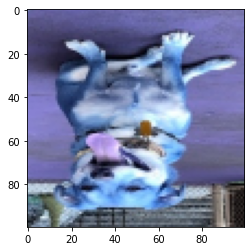

In [4]:
import matplotlib.pyplot as plt

plt.imshow(training_data[10][0])

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

device= torch.device("cuda:0")
device

device(type='cuda', index=0)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(). __init__()
        self.conv1 = nn.Conv2d(3,32,4, stride = 2)
        self.conv2 = nn.Conv2d(32,64,4, stride = 1)
        self.conv3 = nn.Conv2d(64,128,4, stride = 1)
        
        x = torch.rand(100,100,3).view(-1,3,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512) 
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,2)
        

    def convs(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,4,1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,3,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,3,2)
        
        #print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim = 1) 
        
        #return F.softmax(x, dim = 1) 
        #add activation layer
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


In [7]:
import torch.optim as optim


X = torch.Tensor([i[0] for i in training_data]).view(-1,3,100,100)
y = torch.Tensor([i[1] for i in training_data])


In [9]:
VAL_PCT = 0.1  
val_size = int(len(X)*VAL_PCT)


train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(train_y))

print(len(test_X))
print(len(test_y))

14881
14881
1653
1653


In [13]:
BATCH_SIZE = 100
EPOCHS = 150

net.to(device)
net = Net().to(device)


def train(net):
    
    optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
    loss_function = nn.MSELoss()
    
    for epoch in range(EPOCHS):
        #for i in range(0, len(train_X), BATCH_SIZE):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 100, 100)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device),    

            
            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}") 
        
        
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(test_X)):
        #for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 3, 100, 100).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
                
            total += 1
    print("Accuracy: ", round(correct/total, 3))

    
train(net)    

  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 0. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 1. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.70it/s]

Epoch: 2. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.13it/s]

Epoch: 3. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 4. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 5. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.05it/s]

Epoch: 6. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 7. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 8. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 9. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 10. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 11. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 12. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.81it/s]

Epoch: 13. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.93it/s]

Epoch: 14. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.79it/s]

Epoch: 15. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 16. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 17. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 18. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 19. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 20. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.80it/s]

Epoch: 21. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 22. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.16it/s]

Epoch: 23. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 24. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.46it/s]

Epoch: 25. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 26. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.40it/s]

Epoch: 27. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 28. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 29. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 30. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 31. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 32. Loss: 0.4444444477558136


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 33. Loss: 0.22851011157035828


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.57it/s]

Epoch: 34. Loss: 0.21288436651229858


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 35. Loss: 0.2200455665588379


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 36. Loss: 0.2046654373407364


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.60it/s]

Epoch: 37. Loss: 0.21208466589450836


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 38. Loss: 0.1880795657634735


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.30it/s]

Epoch: 39. Loss: 0.16476409137248993


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.80it/s]

Epoch: 40. Loss: 0.15107151865959167


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 41. Loss: 0.1276978850364685


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.16it/s]

Epoch: 42. Loss: 0.11045705527067184


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 43. Loss: 0.10213379561901093


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 44. Loss: 0.09441773593425751


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.14it/s]

Epoch: 45. Loss: 0.0871487408876419


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 46. Loss: 0.08443309366703033


  3%|██▏                                                                               | 4/149 [00:00<00:03, 39.32it/s]

Epoch: 47. Loss: 0.07238083332777023


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 48. Loss: 0.07165531814098358


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 49. Loss: 0.06727651506662369


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.55it/s]

Epoch: 50. Loss: 0.08259977400302887


  3%|██▏                                                                               | 4/149 [00:00<00:04, 34.84it/s]

Epoch: 51. Loss: 0.08553136140108109


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 52. Loss: 0.06901419907808304


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 53. Loss: 0.025057915598154068


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 54. Loss: 0.034567106515169144


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 55. Loss: 0.021780600771307945


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 56. Loss: 0.040319930762052536


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 57. Loss: 0.015763016417622566


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.94it/s]

Epoch: 58. Loss: 0.0305008627474308


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 59. Loss: 0.017696037888526917


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.14it/s]

Epoch: 60. Loss: 0.007912742905318737


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.90it/s]

Epoch: 61. Loss: 0.013992974534630775


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.18it/s]

Epoch: 62. Loss: 0.02080167457461357


  3%|██▏                                                                               | 4/149 [00:00<00:04, 30.38it/s]

Epoch: 63. Loss: 0.0065981303341686726


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.13it/s]

Epoch: 64. Loss: 0.005297394935041666


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.97it/s]

Epoch: 65. Loss: 0.009483003057539463


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.56it/s]

Epoch: 66. Loss: 0.00469592260196805


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.18it/s]

Epoch: 67. Loss: 0.0016407300718128681


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.20it/s]

Epoch: 68. Loss: 0.0025683296844363213


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.82it/s]

Epoch: 69. Loss: 0.00364633253775537


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.55it/s]

Epoch: 70. Loss: 0.003306659637019038


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 71. Loss: 0.0009484027978032827


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.83it/s]

Epoch: 72. Loss: 0.002038674894720316


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.13it/s]

Epoch: 73. Loss: 0.002526590134948492


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.13it/s]

Epoch: 74. Loss: 0.00017973694775719196


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.47it/s]

Epoch: 75. Loss: 0.0029635243117809296


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.83it/s]

Epoch: 76. Loss: 0.0009042057790793478


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 77. Loss: 0.004648223519325256


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 78. Loss: 0.010579023510217667


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.13it/s]

Epoch: 79. Loss: 0.002051230287179351


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.83it/s]

Epoch: 80. Loss: 0.0007305908366106451


  3%|██▏                                                                               | 4/149 [00:00<00:03, 38.19it/s]

Epoch: 81. Loss: 0.006061018444597721


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 82. Loss: 0.013822948560118675


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 83. Loss: 0.0038763233460485935


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.83it/s]

Epoch: 84. Loss: 0.0013467526296153665


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.49it/s]

Epoch: 85. Loss: 0.0023778839968144894


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 86. Loss: 0.0039942325092852116


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.14it/s]

Epoch: 87. Loss: 0.0006998974131420255


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.83it/s]

Epoch: 88. Loss: 0.0025273181963711977


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 89. Loss: 0.0030358245130628347


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.49it/s]

Epoch: 90. Loss: 0.0023918093647807837


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 91. Loss: 0.006076307035982609


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.84it/s]

Epoch: 92. Loss: 0.018215015530586243


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 93. Loss: 0.0005271111731417477


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.61it/s]

Epoch: 94. Loss: 0.00013100687647238374


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 95. Loss: 0.00021462241420522332


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.16it/s]

Epoch: 96. Loss: 0.0013223441783338785


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.12it/s]

Epoch: 97. Loss: 0.0011897076619789004


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.45it/s]

Epoch: 98. Loss: 0.0001539418299216777


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.80it/s]

Epoch: 99. Loss: 0.00042807613499462605


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.11it/s]

Epoch: 100. Loss: 0.012028370052576065


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.82it/s]

Epoch: 101. Loss: 7.1159221988637e-05


  5%|███▊                                                                              | 7/149 [00:00<00:04, 35.25it/s]

Epoch: 102. Loss: 0.004356016870588064


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.79it/s]

Epoch: 103. Loss: 0.0008256144938059151


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.20it/s]

Epoch: 104. Loss: 0.0004941357765346766


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.29it/s]

Epoch: 105. Loss: 0.008024702779948711


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.62it/s]

Epoch: 106. Loss: 0.001114470767788589


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.96it/s]

Epoch: 107. Loss: 0.012762442231178284


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.53it/s]

Epoch: 108. Loss: 7.35511421225965e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.26it/s]

Epoch: 109. Loss: 0.01943829469382763


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.57it/s]

Epoch: 110. Loss: 0.0004161418473813683


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.11it/s]

Epoch: 111. Loss: 0.0005708546959795058


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.14it/s]

Epoch: 112. Loss: 0.0006288534495979548


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.94it/s]

Epoch: 113. Loss: 0.00019066338427364826


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.93it/s]

Epoch: 114. Loss: 0.00044832093408331275


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.47it/s]

Epoch: 115. Loss: 4.866418021265417e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.96it/s]

Epoch: 116. Loss: 0.004741728771477938


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.14it/s]

Epoch: 117. Loss: 0.014692400582134724


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.72it/s]

Epoch: 118. Loss: 0.0013498032931238413


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.03it/s]

Epoch: 119. Loss: 0.00024503422901034355


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.61it/s]

Epoch: 120. Loss: 0.012875224463641644


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.31it/s]

Epoch: 121. Loss: 2.1033891243860126e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.30it/s]

Epoch: 122. Loss: 0.00015643837105017155


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.61it/s]

Epoch: 123. Loss: 0.0006029876531101763


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.27it/s]

Epoch: 124. Loss: 0.0022543547675013542


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.13it/s]

Epoch: 125. Loss: 0.0006871181540191174


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.80it/s]

Epoch: 126. Loss: 0.010895776562392712


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.94it/s]

Epoch: 127. Loss: 0.00024501592270098627


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.13it/s]

Epoch: 128. Loss: 0.0038752707187086344


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.24it/s]

Epoch: 129. Loss: 0.010027940385043621


  3%|██▏                                                                               | 4/149 [00:00<00:04, 33.28it/s]

Epoch: 130. Loss: 0.0010081309592351317


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.93it/s]

Epoch: 131. Loss: 0.002376632299274206


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.30it/s]

Epoch: 132. Loss: 0.00012524702469818294


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.75it/s]

Epoch: 133. Loss: 2.113584014296066e-05


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.81it/s]

Epoch: 134. Loss: 0.0001847342064138502


  3%|██▏                                                                               | 4/149 [00:00<00:04, 31.45it/s]

Epoch: 135. Loss: 1.0825281606230419e-05


  3%|██▏                                                                               | 4/149 [00:00<00:04, 36.13it/s]

Epoch: 136. Loss: 0.01423820573836565


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.30it/s]

Epoch: 137. Loss: 0.0014015018241479993


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.97it/s]

Epoch: 138. Loss: 0.00032534156343899667


  3%|██▏                                                                               | 4/149 [00:00<00:04, 35.81it/s]

Epoch: 139. Loss: 2.2653466658084653e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.60it/s]

Epoch: 140. Loss: 0.0008678315207362175


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.29it/s]

Epoch: 141. Loss: 0.00010209291212959215


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.29it/s]

Epoch: 142. Loss: 0.010058521293103695


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.22it/s]

Epoch: 143. Loss: 0.0021752219181507826


  3%|██▏                                                                               | 4/149 [00:00<00:03, 36.60it/s]

Epoch: 144. Loss: 0.010380232706665993


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 145. Loss: 0.00029573062784038484


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.76it/s]

Epoch: 146. Loss: 3.809261761489324e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.47it/s]

Epoch: 147. Loss: 2.767499245237559e-05


  3%|██▏                                                                               | 4/149 [00:00<00:03, 37.48it/s]

Epoch: 148. Loss: 7.474600806745002e-06


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:04<00:00, 30.83it/s]

Epoch: 149. Loss: 0.007400873117148876


In [14]:
test(net)

Accuracy:  0.848


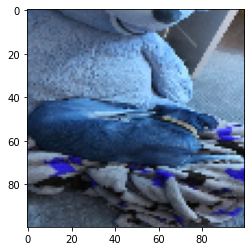

In [46]:
path = r'C:\Users\Cheng Qiu\Documents\Python Scripts\Data Science\Deep Learning Tutorials\4.jpg'
img = cv2.imread(path ,cv2.IMREAD_COLOR)
img = cv2.resize(img,(100, 100))

imgtensor = torch.Tensor(img).view(-1,3,100,100)
plt.imshow(img)

In [47]:
if (torch.argmax(net(imgtensor.to(device))[0])) == 1:
    print("Prediction: MANGO")
else: 
    print("Prediction: NOT MANGO")

Prediction: MANGO


Real Answer: MANGO
Prediction: MANGO


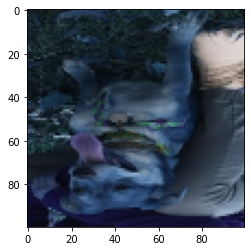

In [77]:
i = 160


plt.imshow((test_X[i]/255).view(100,100,3))

if torch.argmax(test_y[i]) == 1:
    print("Real Answer: MANGO")
else: 
    print("Real Answer: NOT MANGO")
    
    
if (torch.argmax(net(test_X[i].view(-1, 3, 100, 100).to(device))[0])) == 1:
    print("Prediction: MANGO")
else: 
    print("Prediction: NOT MANGO")